# PROVA DE CONCEITO

#   
    Integrantes da Startup: •Eduardo Távora Rocha
                            •Gustavo Antônio Porto Cardoso
                            •Hiago Vinícius Domingues Marques Ribeiro

### CONVOLUÇÃO DA IMAGEM

In [1]:
import os
from PIL import Image
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage import io
from scipy.signal import convolve2d

In [2]:
def show_convolve2d(imagem, kernel, mask=None):

    # Aplica o filtro de média apenas na região definida pela máscara
    imagem_filt = np.zeros(imagem.shape)
    for i in range(3):
        if mask is not None:
            imagem_filt[:, :, i] = imagem[:, :, i] * (1 - mask)
            imagem_filt[:, :, i] += convolve2d(imagem[:, :, i] * mask, kernel, mode='same', boundary='symm')
        else:
            imagem_filt[:, :, i] = convolve2d(imagem[:, :, i], kernel, mode='same', boundary='symm')
    
    # Converte a imagem de volta para o tipo uint8 e exibe as imagens
    imagem_filt = imagem_filt.astype(np.uint8)
    imagem = imagem.astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(8, 6))
    axs[0].imshow(imagem_filt)
    axs[0].set_title('Imagem com filtro de média')
    axs[0].axis('off')
    axs[1].imshow(imagem)
    axs[1].set_title('Imagem original')
    axs[1].axis('off')
    plt.show()
    
    # Salva a imagem filtrada em um arquivo JPEG
    io.imsave(os.path.join('feijão e milho com filtro.jpeg'), imagem_filt)

carregamos a imagem:

In [3]:
filename = os.path.join('foto', 'feijão e milho.jpeg')#imagem carregada do diretório
imagem = io.imread(filename)#comando para ler a imagem

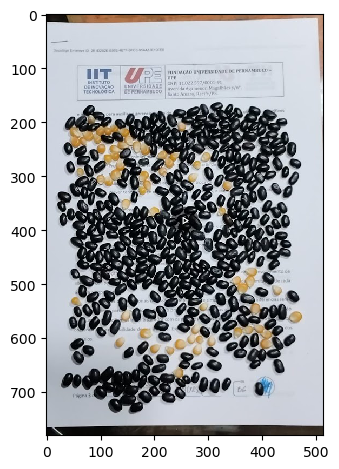

In [4]:
io.imshow(imagem)

Definimos o local da máscara e fazemos a convolução com o filtro de média

In [5]:
mask = np.zeros(imagem.shape[:2])
mask[85:160, 75:430] = 1

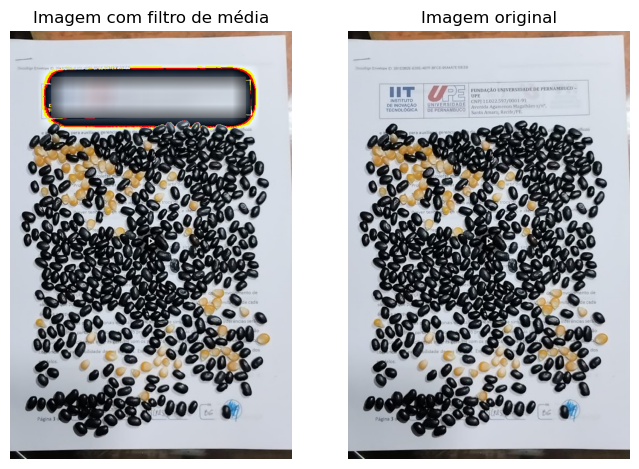

In [6]:
# Define o tamanho do kernel do filtro de média
tam = 50
kernel = np.ones((tam, tam)) / (tam ** 2)

show_convolve2d(imagem, kernel, mask) 

### SEPARANDO O FEIJÃO DO MILHO

Aplica o filtro para separar o feijão do milho:

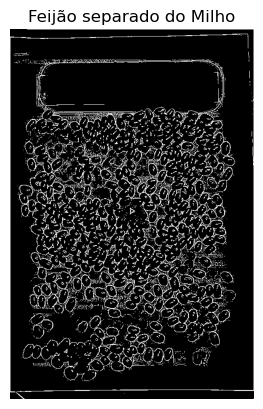

In [7]:
# Carrega a imagem
imagem = Image.open('feijão e milho com filtro.jpeg')

# Converte a imagem para escala de cinza
imagem_cinza = imagem.convert('L')

# Converte a imagem em um array numpy
imagem_array = np.array(imagem_cinza)

# Cria um filtro (kernel) que realce os grãos de feijão
filtro_feijao = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])

# Aplica o filtro à imagem para realçar os grãos de feijão
imagem_realcada_feijao = convolve2d(imagem_array, filtro_feijao, mode='same', boundary='fill', fillvalue=0)


# Cria uma imagem binária (preto e branco) com base na imagem realçada dos grãos de feijão
threshold_feijao = 275
imagem_binaria_feijao = np.where(imagem_realcada_feijao > threshold_feijao, 255, 0).astype('uint8')

# Exibe a imagem filtrada resultante no notebook
plt.imshow(imagem_binaria_feijao, cmap='gray')
plt.title('Feijão separado do Milho')
plt.axis('off')
plt.show()

### CORTANDO A IMAGEM

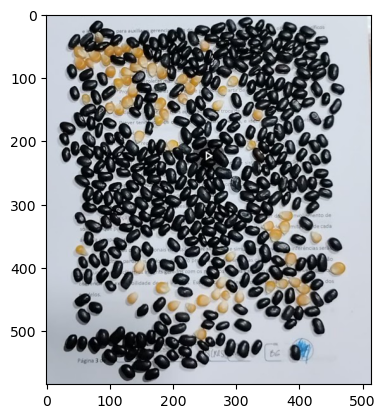

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def crop_image(imagem, mask=None):
    # Define a região de interesse (ROI) que exclui o cabeçalho
    roi = np.zeros(imagem.shape[:2])
    roi[160:-36, :] = 1
    if mask is not None:
        roi *= mask

    # Encontra os limites da ROI
    rows, cols = np.nonzero(roi)
    top, bottom = rows.min(), rows.max()
    left, right = cols.min(), cols.max()

    # Corta a imagem com base na ROI
    imagem_cortada = imagem[top:bottom+1, left:right+1]

    # Exibe a imagem cortada
    plt.imshow(imagem_cortada)
    plt.show()

    # Salva a imagem cortada
    io.imsave('imagem_cortada.jpeg', imagem_cortada.astype(np.uint8))

    
    return imagem_cortada

# Carrega a imagem
filename = os.path.join('foto', 'feijão e milho.jpeg')
imagem = io.imread(filename)

# Chama a função crop_image para cortar a imagem
imagem_cortada = crop_image(imagem)

# Exibe a imagem cortada
plt.show()


### CONTANDO OS GRÃOS DA IMAGEM 

O código abaixo conta todos os grãos da imagem:

In [9]:
import cv2
import numpy as np

In [10]:
# carregar a imagem
img = cv2.imread('imagem_cortada.jpeg')

# converter para escala de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# aplicar filtro gaussiano para suavizar a imagem
blur = cv2.GaussianBlur(gray, (5,5), 0.9)

# aplicar filtro binário adaptativo
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,5,14)

# encontrar contornos
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# contar os grãos
total_graos = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 10 and area < 1000:
        total_graos += 1

# imprimir o total de grãos
print("Total de grãos na imagem: ", total_graos)


Total de grãos na imagem:  460


Abaixo, contamos os grãos de milho e feijão separadamente:

In [11]:
# contar grãos de milho e de feijão preto
milho = 0
feijao = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 10 and area < 1000:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = thresh[y:y+h, x:x+w]
        mean_val = cv2.mean(roi)  # aqui deve ser usada a imagem binarizada roi em vez da imagem original img
        if mean_val[0] >111: # se a média for maior que 112, é um grão de milho
            milho += 1
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)  # desenhar retângulo verde em volta do grão de milho
        else: # caso contrário, é um grão de feijão preto
            feijao += 1
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)  # desenhar retângulo vermelho em volta do grão de feijão preto

# imprimir o total de grãos de milho e de feijão preto
print("Total de grãos de milho: ", milho)
print("Total de grãos de feijão preto: ", feijao)


Total de grãos de milho:  64
Total de grãos de feijão preto:  396


Plotamos a imagem com os contornos feitos para a contagem:

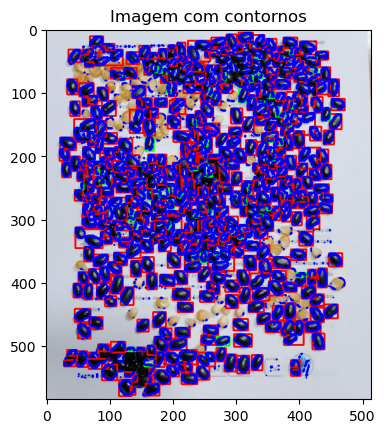

In [24]:
import matplotlib.pyplot as plt

# plotar imagem com contornos
img_contornos = cv2.drawContours(img, contours, -1, (255, 0, 0), 2)
plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
plt.title("Imagem com contornos")
cv2.imwrite("imagem_contornos.jpeg", img)
plt.show()

